# Document classification

In [1]:
!pip list | grep tensorflow

tensorflow-estimator         2.7.0
tensorflow-gpu               2.7.0
tensorflow-io-gcs-filesystem 0.22.0


In [2]:
!nvidia-smi

Tue Apr  5 05:07:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-PCIE-40GB      Off  | 00000000:01:00.0 Off |                    0 |
| N/A   31C    P0    38W / 250W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import transformers

print(transformers.__version__)

4.12.5


In [4]:
# model_checkpoint = "distilbert-base-uncased"
model_checkpoint = "sberbank-ai/ruRoberta-large"

batch_size = 8

## Dataset

In [5]:
import pandas as pd

training_columns=['path', 'text']
# df = pd.read_excel(open('classifier.xlsx', 'rb'), sheet_name='good', index_col=0)
# df = pd.read_excel(open('classifier (17).xlsx', 'rb'), sheet_name='good', index_col=0)
# df = pd.read_excel(open('classifier (29).xlsx', 'rb'), sheet_name='good', index_col=0)
df = pd.read_excel(open('classifier (48).xlsx', 'rb'), sheet_name='good', index_col=0)

df = df[['documentType']+training_columns]
df.head()

,documentType,path,text
0,CONTRACT,Документы\Входящие по практикам\Практика комме...,Договора Поставщик обязался в порядке и на усл...
1,UNKNOWN,Документы\Входящие по практикам\Практика комме...,Акт общей формы № ..20 Станция / фронт выгрузк...
2,POWER_OF_ATTORNEY,Документы\Входящие по практикам\Практика комме...,АКТ отбора образцов (проб) нефтепродуктов г. О...
3,UNKNOWN,Документы\Входящие по практикам\Практика комме...,"наименование организации, осуществляющей прием..."
4,POWER_OF_ATTORNEY,Документы\Входящие по практикам\Практика комме...,"ФССП России, ее территориальный орган или его ..."


In [6]:
len(df)

3610

In [7]:
from pathlib import Path
x = df['path'].transform(lambda x: Path(x.replace('\\','/')).parent.parts[2])
x.unique()

array(['Практика коммерческой логистики',
       'Практика недропользования и экологии',
       'Практика правового сопровождения закупок МТР и услуг общего профиля',
       'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
       'Практика правового сопровождения операционной деятельности БРД',
       'Практика правовой поддержки создания и приобретения ИС',
       'Практика прововой поддержки брендов',
       'Практика промышленной безопасности и охраны труда',
       'Практика судедбной защиты',
       'Практика финансового и конкурентного права',
       'Практика экспорта, оптовых продаж и сбыта бизнес-едениц',
       'Практика поддержки региональных, розничных продаж и клиентского сервиса',
       'Практика правового сопровождения переработки и инфраструктуры',
       'Практика правовой поддержки брендов',
       'Практика правовой поддержки использования и коммерциализации ИС',
       'Практика экспорта, оптовых продаж и сбыта бизнес-единиц'

In [8]:
from pathlib import Path
import os

# df['path'] = df['path'].transform(lambda x: Path(x.replace('\\','/')).parent.parts[-1])
df['path'] = df['path'].transform(lambda x: Path(x.replace('\\','/')).parent.parts[2])

df.head()


,documentType,path,text
0,CONTRACT,Практика коммерческой логистики,Договора Поставщик обязался в порядке и на усл...
1,UNKNOWN,Практика коммерческой логистики,Акт общей формы № ..20 Станция / фронт выгрузк...
2,POWER_OF_ATTORNEY,Практика коммерческой логистики,АКТ отбора образцов (проб) нефтепродуктов г. О...
3,UNKNOWN,Практика коммерческой логистики,"наименование организации, осуществляющей прием..."
4,POWER_OF_ATTORNEY,Практика коммерческой логистики,"ФССП России, ее территориальный орган или его ..."


### Checks

In [9]:
is_NaN = df.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = df[row_has_NaN]
rows_with_NaN

,documentType,path,text


In [10]:
df['text'].dtypes

dtype('O')

In [11]:
df.dtypes

documentType    object
path            object
text            object
dtype: object

In [12]:
df[df['text'].apply(lambda x: not isinstance(x, str))]

,documentType,path,text


In [13]:
xlude = df['text'].apply(lambda x: not isinstance(x, str))
df = df[~xlude]                    

In [14]:
# df = df[df.apply(lambda row: not row['path'].startswith('Исключена'), axis=1)]

### Fix misc. errors

In [15]:

df = df.replace({
    'path': { 
        'Практика правовой поддежрки брендов' : 'Практика правовой поддержки брендов',
        'Практика прововой поддержки брендов' : 'Практика правовой поддержки брендов',
        'Практика экспорта, оптовых продаж и сбыта бизнес-едициниц' : 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц',
        'Практика правового сопровожденияия операционной деятельности БРД' : 'Практика правового сопровождения операционной деятельности БРД',
        'Практика экспорта, оптовых продаж и сбыта бизнес-едениц' : 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц',
    }
})


In [16]:
import pprint as pp
categories = df['path'].unique()
pp.pprint(sorted(categories))

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым '
 'имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки брендов',
 'Практика правовой поддержки использования и коммерциализации ИС',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика промышленной безопасности и охраны труда',
 'Практика судедбной защиты',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц']


In [17]:
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt

%matplotlib inline
# %config InlineBackend.figure_format='retina'
%config InlineBackend.figure_format='png'


rcParams['figure.figsize'] = 12, 8
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Text(0.5, 1.0, 'Количество текстов по темам')

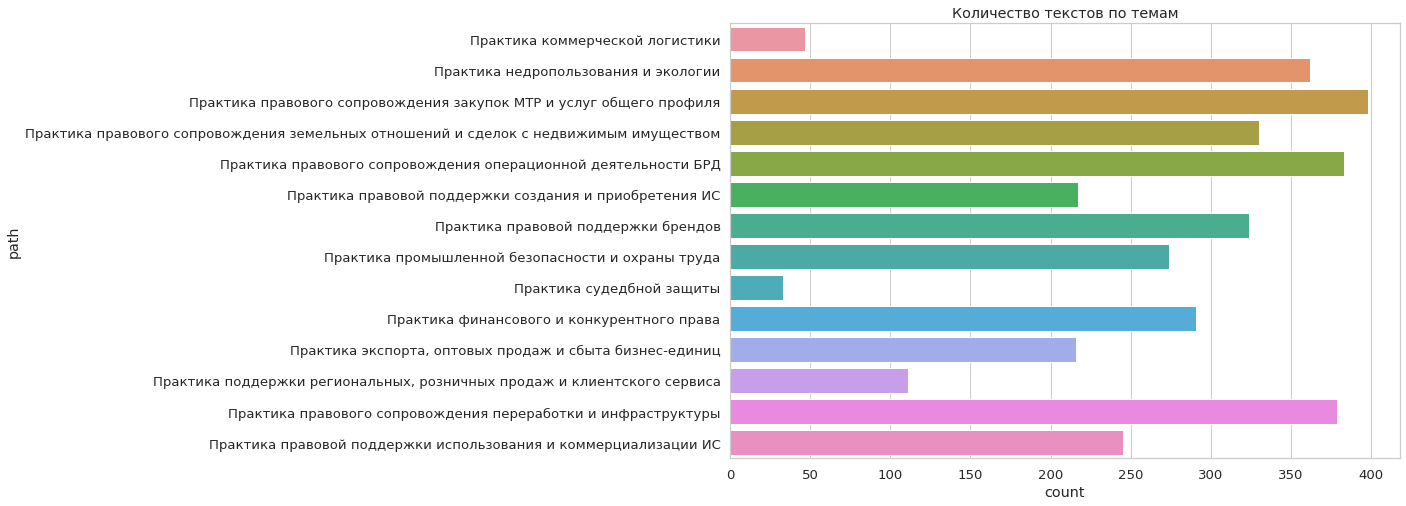

In [18]:
sns.countplot(data=df[training_columns], y='path')
plt.title("Количество текстов по темам")

In [19]:
df['text'][2]

'АКТ отбора образцов (проб) нефтепродуктов г. Омск, ТСБ-2 АО «Газпромнефть-ОНПЗ», железнодорожные пути необщего пользования эстакады тит.519 от "" 2016 г. : (время местн.) Комиссия в составе председателя Представителя ООО «ГПН-Логистика» (доверенность № ГПН-Л/Д- от ..201г.) и членов произвела отбор образцов (проб) нефтепродуктов при приемке по качеству продукции в соответствии с требованиями Инструкции Госарбитража о порядке приемки продукции по качеству П-7, с соблюдением следующих условий: Номер пробы Наимено- вание нефте- продукта (марка по ГОСТ, ТУ) Место отбора пробы (резервуар, транспорт- ное средство, тара и др.) Коли- чество отобран- ной пробы, л Коли- чество нефте- продукта, от которого отобрана проба, т Вид анализа или перечень контроли- руемых показа- телей Существенные условия проведения отбора 1 Топливо для реактивных двигателей ТС-1. ЖД цистерна № 51922904 Контрольный* Грузоотправитель – ООО «ГПН-Логистика» Грузополучатель – ЗАО «Газпромнефть-Аэро» Производитель – АО «Газ

In [20]:
# !pip install datasets
# !pip install -U scikit-learn
# !pip3 install torch

In [21]:
import datasets
categories = categories.tolist()
# datasets.ClassLabel(names=categories)
categories

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика правовой поддержки брендов',
 'Практика промышленной безопасности и охраны труда',
 'Практика судедбной защиты',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки использования и коммерциализации ИС']

### stratified split

In [22]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df[training_columns], test_size=0.08,  stratify=df[['path']])

In [23]:
c1 = train_df['path'].unique()
c2 = test_df['path'].unique()

if len(c1)!=len(c2):
    print('Error: bad split by categories!')

Text(0.5, 1.0, 'Количество текстов по темам в test set')

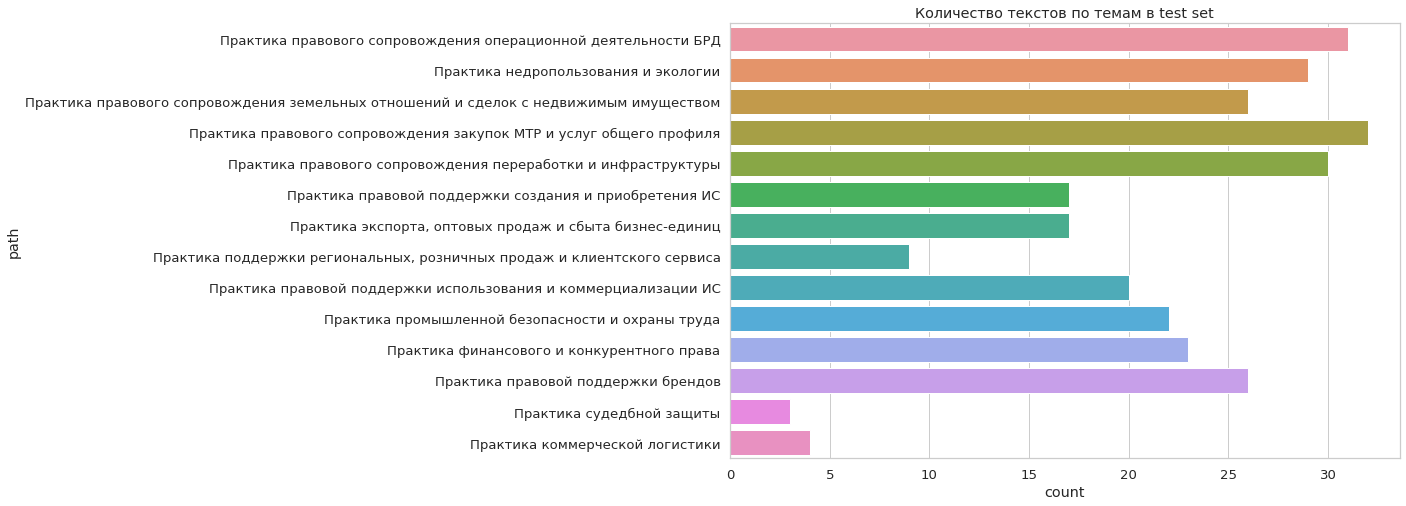

In [24]:
sns.countplot(data=test_df, y='path')
plt.title("Количество текстов по темам в test set")

In [25]:
import tensorflow as tf
from datasets import Dataset
categories_feature=datasets.ClassLabel(names=categories)
features = datasets.Features({'path': categories_feature})

# dataset = Dataset.from_pandas(df[training_columns])

trainset = Dataset.from_pandas(train_df)
testset = Dataset.from_pandas(test_df)

In [26]:
trainset

Dataset({
    features: ['path', 'text', '__index_level_0__'],
    num_rows: 3321
})

In [27]:
testset

Dataset({
    features: ['path', 'text', '__index_level_0__'],
    num_rows: 289
})

In [28]:
trainset.features

{'path': Value(dtype='string', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [29]:
def convert_to_class_label(row):
    row['path'] = categories_feature.str2int(row['path'])
    return row
# updated_dataset = dataset.map(convert_to_class_label)
trainset = trainset.map(convert_to_class_label)
testset = testset.map(convert_to_class_label)


  0%|          | 0/3321 [00:00<?, ?ex/s]

  0%|          | 0/289 [00:00<?, ?ex/s]

### casting features

In [30]:
trainset.features

{'path': Value(dtype='int64', id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [31]:
from datasets import ClassLabel, Value
new_features = trainset.features.copy()
new_features["path"] = ClassLabel(names=categories)

trainset = trainset.cast(new_features)
testnset = testset.cast(new_features)

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

Casting the dataset:   0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
trainset=trainset.shuffle(seed=42)
testset=testset.shuffle(seed=42)
trainset['path'][:5]

[2, 1, 6, 4, 11]

In [33]:
# work_dataset = updated_dataset.train_test_split(test_size=0.1)
# work_dataset

trainset.features

{'path': ClassLabel(num_classes=14, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правовой поддержки создания и приобретения ИС', 'Практика правовой поддержки брендов', 'Практика промышленной безопасности и охраны труда', 'Практика судедбной защиты', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки использования и коммерциализации ИС'], names_file=None, id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

## Metric

In [34]:
from datasets import load_dataset, load_metric
# metric = load_metric('glue','mrpc')
metric = load_metric('glue','sst2')

pp.pprint(metric)

Metric(name: "glue", features: {'predictions': Value(dtype='int64', id=None), 'references': Value(dtype='int64', id=None)}, usage: """
Compute GLUE evaluation metric associated to each GLUE dataset.
Args:
    predictions: list of predictions to score.
        Each translation should be tokenized into a list of tokens.
    references: list of lists of references for each translation.
        Each reference should be tokenized into a list of tokens.
Returns: depending on the GLUE subset, one or several of:
    "accuracy": Accuracy
    "f1": F1 score
    "pearson": Pearson Correlation
    "spearmanr": Spearman Correlation
    "matthews_correlation": Matthew Correlation
Examples:

    >>> glue_metric = datasets.load_metric('glue', 'sst2')  # 'sst2' or any of ["mnli", "mnli_mismatched", "mnli_matched", "qnli", "rte", "wnli", "hans"]
    >>> references = [0, 1]
    >>> predictions = [0, 1]
    >>> results = glue_metric.compute(predictions=predictions, references=references)
    >>> print(res

## Preprocessing data

In [35]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [36]:
tokenizer("""
2.2. Технические, экономические, научные и другие требования к результатам Услуг, а также краткое содержание и сроки оказания основных этапов Услуг, являющиеся предметом настоящего Договора, изложены в Приложении № 1 «Техническое задание», составляющем неотъемлемую часть настоящего Договора.
2.3. Результат Услуг используется Заказчиком при организации работ по охране окружающей среды, а также в качестве отчетных материалов для полномочных надзорных органов.

""")

{'input_ids': [1, 203, 22, 18, 22, 18, 12424, 20833, 16, 24248, 16, 24870, 289, 2316, 8013, 294, 16478, 615, 486, 954, 16, 376, 1196, 6501, 2564, 10217, 289, 15419, 36574, 10350, 44019, 615, 486, 954, 16, 25565, 3116, 18594, 11388, 20429, 264, 16, 12810, 929, 281, 26164, 370, 807, 3722, 514, 440, 32428, 33063, 12271, 766, 23293, 327, 31524, 499, 2205, 11388, 20429, 264, 18, 203, 22, 18, 23, 18, 40093, 615, 486, 954, 12785, 5229, 340, 8695, 530, 4503, 827, 341, 24584, 18455, 14013, 16, 376, 1196, 281, 3396, 6018, 474, 12059, 582, 5236, 6673, 35160, 474, 8503, 18, 203, 203, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [37]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True, max_length=512)


In [38]:
trainset[19]

{'path': 1,
 'text': '6 плана по предупреждению и ликвидации разливов нефти и нефтепродуктов на объектах АО «Газпромнефть- Ноябрьскнефтегаз», введенным в действие приказом предприятия от 22.03.2019 №216/1-П: не проводится средний ремонт резервуаров ДНС с УПСВ Карамовского месторождения с выводом их из эксплуатации, который включает зачистку донных отложений, составление дефектных ведомостей, выполнение ремонта, запуск в работу. пункт 10 статья 46 Федерального закона от 10.01.2002 № 7-ФЗ «Об охране окружающей среды»; пункт 7 части 2 статьи 22 закона РФ от 21.02.1992 № 2395-1 «О недрах». 23.11.2021 32. Не обеспечивается соблюдение обязательных требований по статья 12, пункт 2 части 2 статьи 13, статья 42 Земельного кодекса Российской Федерации от 25 23.11.2021 Газпромнефгь-Ноябрьскнефгегаз, АО (Газ охране земель: на территории ДНС с УПСВ Карамовского месторождения отсутствует ливневая канализация, сброс неочищенных производственнодождевых сточных вод с территории ДНС с УПСВ осуществляетс

In [39]:
preprocess_function(trainset[19])

{'input_ids': [1, 26, 11506, 341, 7905, 974, 289, 20781, 18573, 292, 11443, 289, 28718, 18054, 733, 324, 50070, 41468, 440, 23469, 18261, 550, 17, 395, 636, 315, 1937, 334, 461, 12618, 39199, 766, 6890, 1760, 281, 8196, 33960, 10178, 362, 4768, 18, 18059, 18, 2222, 1800, 3722, 22, 3535, 19, 21, 17, 613, 30, 332, 19135, 21487, 10662, 9181, 272, 2210, 455, 631, 561, 280, 615, 22009, 596, 21167, 11717, 41283, 280, 3836, 300, 651, 411, 21163, 16, 961, 15675, 2473, 49256, 5025, 474, 14366, 942, 16, 1378, 1110, 46947, 474, 5998, 7165, 16, 19387, 23649, 16, 10505, 281, 2852, 18, 5972, 2176, 16367, 15427, 35129, 7851, 362, 2176, 18, 16633, 18, 42289, 3722, 1969, 17, 37418, 440, 4892, 24584, 18455, 14013, 11165, 5972, 1969, 2558, 626, 8873, 4768, 7851, 3311, 362, 5536, 18, 17898, 18, 10291, 22, 3722, 5073, 18115, 17, 21, 440, 608, 38537, 714, 5073, 18, 4290, 18, 2222, 6804, 12612, 18, 881, 3431, 2949, 47434, 1986, 6624, 18825, 341, 16367, 2723, 16, 5972, 626, 2558, 626, 8873, 3288, 16, 16367, 1

In [40]:
trainset.features

{'path': ClassLabel(num_classes=14, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правовой поддержки создания и приобретения ИС', 'Практика правовой поддержки брендов', 'Практика промышленной безопасности и охраны труда', 'Практика судедбной защиты', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки использования и коммерциализации ИС'], names_file=None, id=None),
 'text': Value(dtype='string', id=None),
 '__index_level_0__': Value(dtype='int64', id=None)}

In [41]:
pre_tokenizer_columns = set(trainset.features)
print(f'pretokenized columns: {pre_tokenizer_columns}')

trainset = trainset.map(preprocess_function, batched=True)
testset = testset.map(preprocess_function, batched=True)

tokenizer_columns = list(set(trainset.features) - pre_tokenizer_columns)
print("Columns added by tokenizer:", tokenizer_columns)

pretokenized columns: {'path', 'text', '__index_level_0__'}


  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

Columns added by tokenizer: ['input_ids', 'attention_mask']


In [42]:
trainset.features["path"]

ClassLabel(num_classes=14, names=['Практика коммерческой логистики', 'Практика недропользования и экологии', 'Практика правового сопровождения закупок МТР и услуг общего профиля', 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом', 'Практика правового сопровождения операционной деятельности БРД', 'Практика правовой поддержки создания и приобретения ИС', 'Практика правовой поддержки брендов', 'Практика промышленной безопасности и охраны труда', 'Практика судедбной защиты', 'Практика финансового и конкурентного права', 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц', 'Практика поддержки региональных, розничных продаж и клиентского сервиса', 'Практика правового сопровождения переработки и инфраструктуры', 'Практика правовой поддержки использования и коммерциализации ИС'], names_file=None, id=None)

In [43]:
trainset

Dataset({
    features: ['__index_level_0__', 'attention_mask', 'input_ids', 'path', 'text'],
    num_rows: 3321
})

In [44]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")


tf_train_dataset = trainset.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
tf_validation_dataset = testset.to_tf_dataset(
    columns=tokenizer_columns,
    label_cols=["path"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

2022-04-05 05:07:48.134312: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 05:07:48.138137: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 05:07:48.138799: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-05 05:07:48.139853: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

## Fine-tuning the model

In [50]:
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf

from pathlib import Path
saved_model_path=Path.cwd() / 'doc-classification'

loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
num_labels = categories_feature.num_classes

# if saved_model_path.exists():
#     model = TFAutoModelForSequenceClassification.from_pretrained(str(saved_model_path), from_pt=False)
#     print(f'loaded from: {str(saved_model_path)}')
# else:
model = TFAutoModelForSequenceClassification.from_pretrained(
    model_checkpoint, num_labels=num_labels, from_pt=True
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predicti

In [51]:
from transformers import create_optimizer

num_epochs = 6
batches_per_epoch = len(trainset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)
model.compile(optimizer=optimizer, loss=loss)

In [52]:
# if model exists load

In [53]:
metric_name='accuracy'
task = 'mrpc'

def compute_metrics(predictions, labels):
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)


### Fit

In [54]:
from transformers.keras_callbacks import PushToHubCallback

model_name = model_checkpoint.split("/")[-1]

history = model.fit(
    tf_train_dataset,
    validation_data=tf_validation_dataset,
    epochs=num_epochs,
    # callbacks=[callback],
)

Epoch 1/6
415/415 [==============================] - 163s 356ms/step - loss: 1.5760 - val_loss: 1.1090
Epoch 2/6
415/415 [==============================] - 146s 351ms/step - loss: 0.8201 - val_loss: 0.9189
Epoch 3/6
415/415 [==============================] - 146s 352ms/step - loss: 0.4690 - val_loss: 0.8961
Epoch 4/6
415/415 [==============================] - 146s 352ms/step - loss: 0.2827 - val_loss: 0.8571
Epoch 5/6
415/415 [==============================] - 146s 353ms/step - loss: 0.1711 - val_loss: 0.8800
Epoch 6/6
415/415 [==============================] - 146s 352ms/step - loss: 0.1271 - val_loss: 0.8858


In [55]:

history.history

{'loss': [1.5760058164596558,
  0.8201071619987488,
  0.46898218989372253,
  0.2827361524105072,
  0.1710965484380722,
  0.12714222073554993],
 'val_loss': [1.1089931726455688,
  0.9188776016235352,
  0.8961445689201355,
  0.8570569157600403,
  0.8800496459007263,
  0.8858126997947693]}

In [56]:
model.config


RobertaConfig {
  "_name_or_path": "sberbank-ai/ruRoberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 1,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13"
  },
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "layer_norm_

In [57]:
model.save_pretrained('doc-classification')

## Evaluate

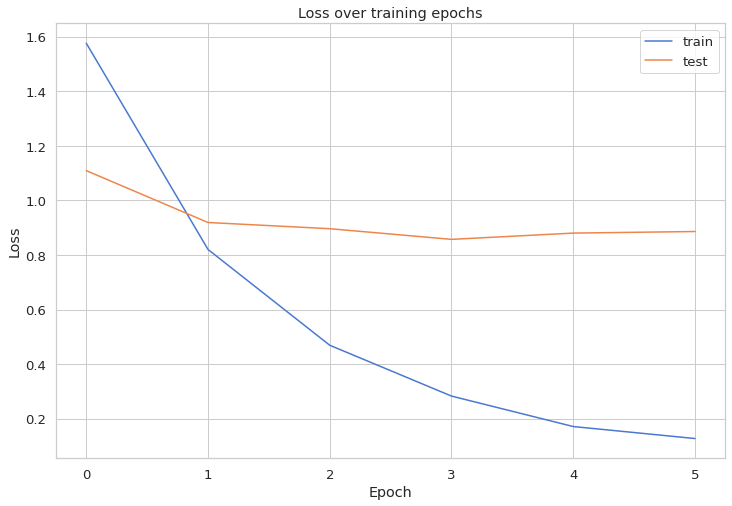

In [58]:
from matplotlib.ticker import MaxNLocator
#@title Loss over training epochs
ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [59]:
predictions = model.predict(tf_validation_dataset)["logits"]

In [60]:
import numpy as np
compute_metrics(predictions, np.array(testset["path"]))

{'accuracy': 0.7647058823529411}

In [61]:
# model.evaluate(tf_train_dataset)

In [62]:
#@title Accuracy
# _, train_acc = model.evaluate(data.train_x, data.train_y)
# _, test_acc = model.evaluate(data.test_x, data.test_y)

# print("train acc", train_acc)
# print("test acc", test_acc)

model.evaluate(tf_validation_dataset)

37/37 [==============================] - 4s 109ms/step - loss: 0.8858


0.8858126997947693

In [63]:
from sklearn.metrics import confusion_matrix, classification_report
y_pred = np.argmax(predictions, axis=1)
y_pred

array([ 9,  1,  9,  1,  2, 12, 12,  3,  5, 10, 13,  1, 13, 11,  3,  4, 11,
        7, 12,  2, 12, 13, 11,  2, 10,  7,  4,  2,  1,  6,  3,  7,  3,  1,
        1,  1,  4,  2,  5,  5, 13,  7,  1,  1,  6,  9,  9, 13,  6, 12,  2,
       11, 13,  5, 10, 10,  2,  0,  1, 13,  4, 12,  0,  7, 10,  6,  7,  4,
        2,  5,  5,  6,  6,  4,  9,  6,  6,  3, 12,  5,  9,  4,  1,  9,  6,
        9,  2,  2,  7,  1, 13,  5, 13,  3,  7,  3,  5,  2,  4,  3,  4,  5,
        6,  7,  3,  4,  9, 10,  4, 11,  6,  4,  7,  9,  2,  7, 12, 12,  6,
       10,  6,  5,  9,  1,  2,  6, 10,  4, 12,  1,  2,  1,  6,  9, 10, 13,
        7,  0,  4,  2,  6,  6,  3,  1,  4, 12,  6, 10,  7, 12, 12, 11,  8,
        4,  2,  6,  5,  7, 13, 11,  4,  7,  8,  1,  1, 12, 13,  9,  0,  6,
        9,  2,  3,  4, 13,  9,  4,  4,  1,  6,  3,  7,  3,  3,  9,  2,  1,
       11, 13,  3, 12,  5,  1,  6, 12,  7,  3,  5,  7,  3,  9, 13,  4, 12,
       11, 10, 12,  3, 13,  2,  0, 12,  2, 10,  1, 13,  6,  7,  6, 13,  9,
        3,  2,  7,  2, 11

In [64]:
y = np.concatenate([y for x, y in tf_validation_dataset], axis=0)
y

array([ 9,  1,  9,  1,  2, 12,  4,  3,  5, 10, 13,  1,  5, 11,  3,  4,  6,
        7, 12,  2, 12,  7,  2,  6, 10,  7,  4,  3,  7,  6,  3,  3,  3,  1,
        1,  1,  4,  2,  5,  5, 13,  7,  1,  1,  6,  9,  9, 13,  6, 12,  2,
       11, 13,  5, 10,  2,  2,  0,  1, 13,  2, 12, 10,  7, 10,  6,  7,  4,
        9,  5,  5,  6,  6,  4,  2,  6, 11,  3,  3,  5,  9,  1,  1,  9,  6,
        9,  2,  2,  7,  6, 13,  5, 13,  3,  7,  3,  5,  4,  4,  3,  4,  4,
       13,  7,  3,  4,  9, 10,  4, 11,  6,  4,  7,  9,  2,  8, 12, 12,  6,
       10,  6,  5,  1,  2, 12, 12, 10, 12, 12,  1,  7,  1,  6,  9, 10,  6,
        7,  0,  4,  2,  6,  6,  3,  3,  4, 12,  6, 10,  2, 12, 12, 11,  1,
        4, 11,  6,  5,  3, 13,  8,  4,  7,  4,  1,  1, 12, 12,  9,  0,  6,
        9,  2,  3,  4,  2,  9,  4,  4,  1,  6,  3,  7,  3,  3,  9,  2,  1,
        6, 13,  3, 12, 13, 11,  9, 12,  5,  3,  5,  7,  3,  2, 13,  4, 12,
       11, 10, 12,  3,  9,  2,  0, 12, 13, 10,  3, 13,  6,  7,  1, 12,  9,
        3,  2,  4,  2, 10

In [65]:
categories_feature.names

['Практика коммерческой логистики',
 'Практика недропользования и экологии',
 'Практика правового сопровождения закупок МТР и услуг общего профиля',
 'Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом',
 'Практика правового сопровождения операционной деятельности БРД',
 'Практика правовой поддержки создания и приобретения ИС',
 'Практика правовой поддержки брендов',
 'Практика промышленной безопасности и охраны труда',
 'Практика судедбной защиты',
 'Практика финансового и конкурентного права',
 'Практика экспорта, оптовых продаж и сбыта бизнес-единиц',
 'Практика поддержки региональных, розничных продаж и клиентского сервиса',
 'Практика правового сопровождения переработки и инфраструктуры',
 'Практика правовой поддержки использования и коммерциализации ИС']

In [68]:
categories_feature.int2str(12)

'Практика правового сопровождения переработки и инфраструктуры'

In [69]:
# categories_feature.str2int('Практика экспорта, оптовых продаж и сбыта бизнес-едениц')

In [70]:
# workaround for report
# y_pred = np.concatenate((y_pred,[0]),axis=0)
# y_pred

In [71]:
# y = np.concatenate((y,[0]),axis=0)
# y

In [72]:
#@title Classification report
print(classification_report(y, y_pred, target_names=categories_feature.names))

                                                                                       precision    recall  f1-score   support

                                                      Практика коммерческой логистики       0.80      1.00      0.89         4
                                                 Практика недропользования и экологии       0.72      0.79      0.75        29
                  Практика правового сопровождения закупок МТР и услуг общего профиля       0.63      0.59      0.61        32
Практика правового сопровождения земельных отношений и сделок с недвижимым имуществом       1.00      0.77      0.87        26
                       Практика правового сопровождения операционной деятельности БРД       0.87      0.84      0.85        31
                               Практика правовой поддержки создания и приобретения ИС       0.88      0.82      0.85        17
                                                  Практика правовой поддержки брендов       0.75      0.81    

In [73]:
cm = confusion_matrix(y, y_pred)
df_cm = pd.DataFrame(cm, index=categories_feature.names, columns=categories_feature.names)

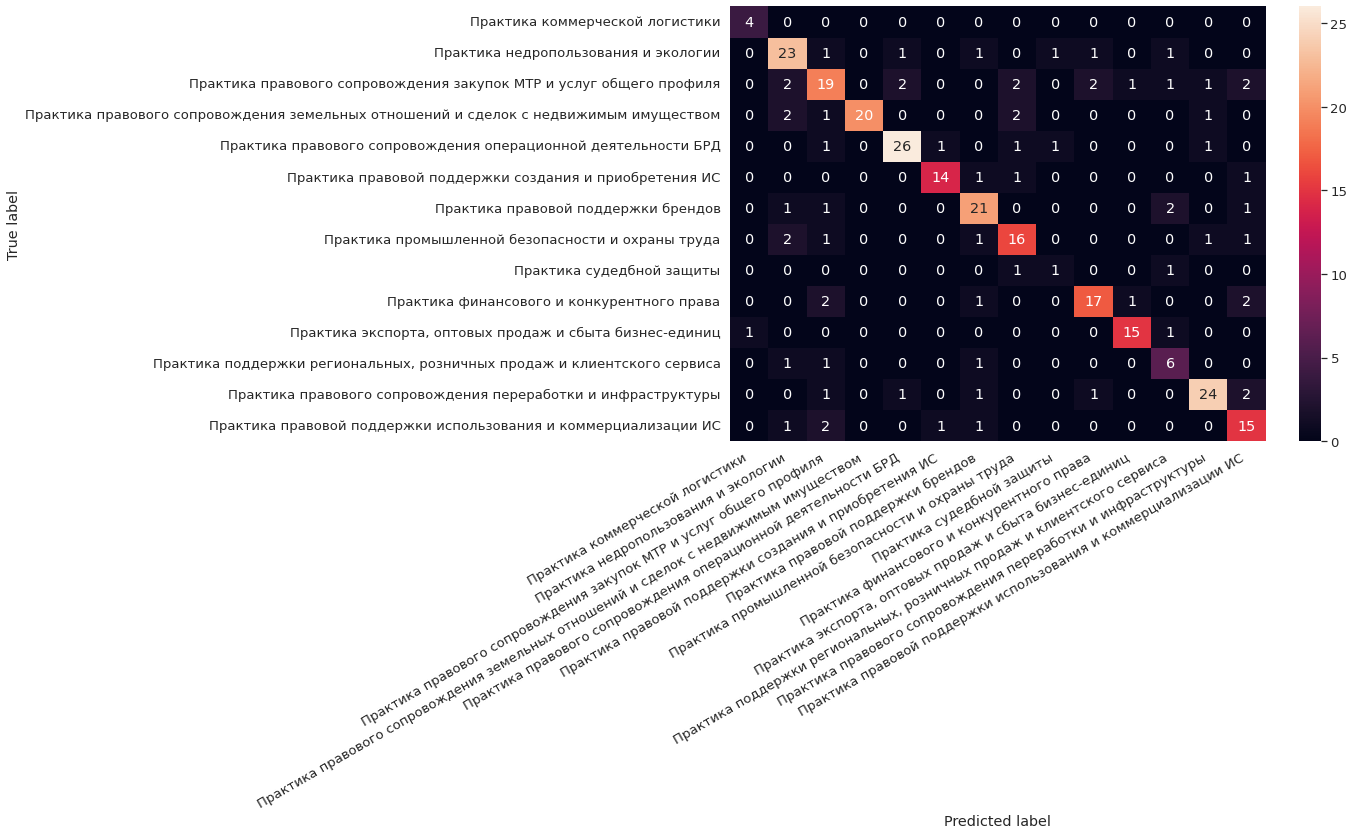

In [74]:
#@title Confusion matrix
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

## Predict

In [75]:
tf_validation_dataset

<PrefetchDataset shapes: ({input_ids: (None, None), attention_mask: (None, None)}, (None,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.int64)>

In [76]:
text = '''
1.1. Заказчик поручает, а Исполнитель обязуется своими силами оказать Заказчику услуги по поиску, привлечению и отбору кандидатов, соответствующих требованиям Заказчика, на вакантные должности последнего на постоянную и временную работу на АЗС, более подробно описанные в Приложении № 1.
Услуги оказываются Исполнителем с __________________
1.2. По неисполненным денежным обязательствам договор действует до полного исполнения сторонами таких обязательств.
1.3. Отношения, возникающие по настоящему Договору, не являются трудовыми и регулируются исключительно гражданским законодательством. Исполнитель не включается в штат работников Заказчика, правила внутреннего трудового распорядка, утвержденные Заказчиком, на Исполнителя не распространяются. Исполнитель не получает прав, льгот и компенсаций, предусмотренных действующим трудовым законодательством для работников, выполняющих свою работу по трудовому договору (контракту). Заказчик не обязан осуществлять страхование Исполнителя от несчастного случая на производстве и профессиональных заболеваний.

'''
r = tokenizer(text, truncation=True, max_length=512)

In [77]:
r

{'input_ids': [1, 203, 21, 18, 21, 18, 5229, 340, 1445, 4935, 456, 16, 376, 37569, 540, 1986, 3238, 2924, 8296, 15236, 5229, 340, 15963, 12142, 341, 3475, 272, 16, 16113, 974, 289, 13116, 272, 18149, 16, 23478, 21846, 5229, 340, 5376, 16, 324, 18015, 892, 475, 9346, 7086, 324, 43824, 289, 642, 2705, 2852, 324, 448, 1229, 561, 16, 1027, 10921, 3265, 2592, 281, 26164, 370, 807, 331, 19846, 514, 18, 203, 1133, 486, 5088, 24689, 37569, 4152, 280, 225, 15680, 2414, 203, 21, 18, 22, 18, 945, 14664, 819, 268, 1760, 8221, 480, 20097, 338, 2986, 10123, 624, 11214, 16524, 36997, 2479, 20097, 18, 203, 21, 18, 23, 18, 1200, 19199, 16, 6764, 4275, 341, 28728, 20429, 272, 16, 332, 5291, 1566, 7972, 289, 15107, 33702, 6910, 2626, 1634, 35752, 18, 37569, 540, 332, 2617, 704, 281, 9644, 13095, 5229, 340, 5376, 16, 7879, 14437, 45505, 10821, 428, 16, 4707, 1209, 5229, 340, 8695, 16, 324, 37569, 1611, 332, 3894, 8891, 18, 37569, 540, 332, 10915, 720, 16, 28722, 289, 15907, 1971, 16, 49980, 43457, 1566, 3

In [78]:
predictions = model.predict([r['input_ids']])['logits']

In [79]:
predictions

array([[-0.97516304, -0.81925535,  0.03437575,  0.16181523, -1.7520218 ,
        -0.90908664,  2.466536  ,  1.0012646 , -0.8184208 , -1.6355081 ,
        -0.4760337 ,  5.8219595 , -0.12355451, -1.115612  ]],
      dtype=float32)

In [80]:
predictions = np.argmax(predictions, axis=1)

In [81]:
predictions

array([11])

In [82]:
categories_feature.int2str(int(predictions[0]))

'Практика поддержки региональных, розничных продаж и клиентского сервиса'